In [2]:
import os
import nltk
import re
import numpy as np
from hazm import word_tokenize, Lemmatizer, Stemmer, Normalizer
from pprint import pprint
import pandas as pd

In [3]:
raw_text = pd.read_csv('Shams_Corpus_Paper3.txt')
raw_text.iloc[5]

دیوان شمس تبریزی (غزلیات)    صورت دل صورت مخلوق نیست\tکز رخ دل حسن خدا رو نمود
Name: 5, dtype: object

In [4]:
file = open(os.getcwd() + "/Shams_Corpus_Paper3.txt", "rt")
raw_text = file.read()
file.close()


In [6]:
raw_text

'دیوان شمس تبریزی (غزلیات)\n\n1001 - 1500\n\n--------------------------------------------------------\n\n\n\n1001\n\nآه در آن شمع منور چه بود\tکآتش زد در دل و دل را ربود\n\nای زده اندر دل من آتشی\tسوختم ای دوست بیا زود زود\n\nصورت دل صورت مخلوق نیست\tکز رخ دل حسن خدا رو نمود\n\nجز شکرش نیست مرا چاره ای\tجز لب او نیست مرا هیچ سود\n\nیاد کن آن را که یکی صبحدم\tاین دلم از زلف تو بندی گشود\n\nجان من اول که بدیدم تو را\tجان من از جان تو چیزی شنود\n\nچون دلم از چشمه تو آب خورد\tغرقه شد اندر تو و سیلم ربود\n\n\n\n1002\n\nچونک کمند تو دلم را کشید\tیوسفم از چاه به صحرا دوید\n\nآنک چو یوسف به چهم درفکند\tباز به فریادم هم او رسید\n\nچون رسن لطف در این چه فکند\tچنبره دل گل و نسرین دمید\n\nقیصر از آن قصر به چه میل کرد\tچه چو بهشتی شد و قصر مشید\n\nگفتم ای چه چه شد آن ظلمتت\tگفت که خورشید به من بنگرید\n\nهر که فسردست کنون گرم شد\tجمره عشقت بگدازد جلید\n\nقیصر رومست که بر زنگ زد\tاوست که ترسابچه خواندش فرید\n\nپرتو دل بود که زد بر سعیر\tپر شد و بشکافت که هل من مزید\n\nدوزخ گفتش که مرا جان ببخش\tتا بخ

In [5]:
def remove_persian_stopword(tokens):
    file = open(os.getcwd() + "/persian_stopw.txt", "rt")
    raw_stop_words = file.read()
    file.close()

    stop_words = word_tokenize(raw_stop_words)

    return [word for word in tokens if not word in stop_words]

In [6]:
def normalize_text(text):
    normalizer = Normalizer()
    
    return normalizer.normalize(text)

In [7]:
def lemma_tokenizer(tokens):
    lemmatizer = Lemmatizer()    
    return [lemmatizer.lemmatize(token) for token in tokens]

In [8]:
def stem_tokenizer(tokens):
    stemmer = Stemmer()
    return [stemmer.stem(token) for token in tokens]

In [9]:
raw_text = "".join([i for i in raw_text if not i.isdigit()])
raw_text = re.sub(r"-+|\d+", "", raw_text)

raw_text = normalize_text(raw_text)

raw_tokens = word_tokenize(raw_text)
len(raw_tokens)

78389

In [11]:
type(raw_tokens)

list

In [70]:
tokens = remove_persian_stopword(raw_tokens[:2000])
len(tokens)

1405

In [14]:
lammatized_tokens = lemma_tokenizer(tokens)
pprint(lammatized_tokens[90:100])

stemmed_tokens = stem_tokenizer(tokens)
pprint(stemmed_tokens[90:100])

['قیصر', 'قصر', 'میل', 'چو', 'بهشتی', 'قصر', 'مشید', 'گفت#گو', 'ای', 'ظلمت']
['قیصر', 'قصر', 'میل', 'چو', 'بهشت', 'قصر', 'مشید', 'گف', 'ا', 'ظلمت']


In [15]:
tokens[90:100]

['قیصر', 'قصر', 'میل', 'چو', 'بهشتی', 'قصر', 'مشید', 'گفتم', 'ای', 'ظلمتت']

In [16]:
import tensorflow as tf

2022-05-03 02:10:00.420346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 02:10:00.420434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
tf

<module 'tensorflow' from '/home/emoji/anaconda3/envs/first_numpy_pandas/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [3]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [17]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [18]:
tokens = tokenize(text)
tokens

NameError: name 'tokenize' is not defined

In [18]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [71]:
word_to_id, id_to_word = mapping(tokens)
word_to_id

{'میوه': 0,
 'بلبل': 1,
 'بیاور': 2,
 'نرهد': 3,
 'نحله': 4,
 'نصف': 5,
 'عیونی': 6,
 'بلافد': 7,
 'شاد': 8,
 'ترید': 9,
 'قوموا': 10,
 'میر': 11,
 'جغدان': 12,
 'نورم': 13,
 'جبریل': 14,
 'محبته': 15,
 'سبوی': 16,
 'تهیجنی': 17,
 'ولود': 18,
 'اولهم': 19,
 'خرقه\u200cای': 20,
 'غرقه': 21,
 'خورد': 22,
 'بردمید': 23,
 'روح': 24,
 'آ': 25,
 'التناد': 26,
 'بدو': 27,
 'جهان': 28,
 'خوبی': 29,
 'صیاد': 30,
 'گرم': 31,
 'عشقت': 32,
 'الفتور': 33,
 'رها': 34,
 'بیدی': 35,
 'رویش': 36,
 'تشنیع': 37,
 'شمر': 38,
 'للاجتهاد': 39,
 'انگور': 40,
 'درا': 41,
 'گریزان': 42,
 'سر': 43,
 'آدمی': 44,
 'حلو': 45,
 'ایدک': 46,
 'ساقی': 47,
 'بیشه\u200cای': 48,
 'گریبان': 49,
 'درآمد': 50,
 'عیون': 51,
 'ساکن': 52,
 'صبحدم': 53,
 'نماند': 54,
 'ودود': 55,
 'بشر': 56,
 'بالمنتصر': 57,
 'بکشد': 58,
 'تن': 59,
 'خوبست': 60,
 'خاصا': 61,
 'شرم': 62,
 'مو': 63,
 'بقاست': 64,
 'یهولنکم': 65,
 'یار': 66,
 'مرتفع': 67,
 'برغم': 68,
 'عمان': 69,
 'الموات': 70,
 'یعید': 71,
 'رسن': 72,
 'الکرام': 73,
 'قصر': 74,


In [72]:
len(word_to_id)

968

In [21]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [22]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [23]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [74]:
X, y = generate_training_data(tokens, word_to_id, 4)


In [75]:
print(y[5:9] ,sep = '\n')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [76]:
print(X[5:9] ,sep = '\n')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [77]:
X.shape

(11220, 968)

In [78]:
y.shape

(11220, 968)

In [79]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [80]:
model = init_network(len(word_to_id), 10)
model["w1"].shape

(968, 10)

In [81]:
model["w2"].shape

(10, 968)

In [82]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [83]:
X.shape

(11220, 968)

In [84]:
(X @ model["w1"]).shape

(11220, 10)

In [85]:
(X @ model["w1"] @ model["w2"]).shape


(11220, 968)

In [36]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

In [37]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [38]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

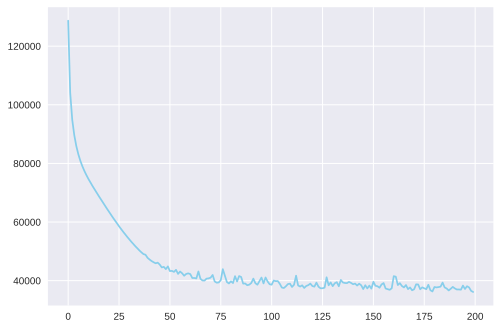

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

model = init_network(len(word_to_id), 10)

n_iter = 200
learning_rate = 0.01

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [87]:
len(history)

200

In [51]:
np.argsort(result)[::-1][0:5]

array([ 15, 456, 179,  66, 263])

In [52]:
for word in (id_to_word[id] for id in np.argsort(result)[::-1][0:10]):
    print(word)


عشقت
فسردست
جمره
کنون
بگدازد
گرم
جانان
قد
بس
بنگرید


In [53]:
def get_word_similarities(word, model, n_similars=10):
    try:
        learning = one_hot_encode(word_to_id[word], len(word_to_id))
    except KeyError:
        print(f"Word = {word} is not in corpus")
        exit()
    result = forward(model, [learning], return_cache=False)[0]
    for word in (id_to_word[id] for id in np.argsort(result)[::-1][0:n_similars]):
        print(word)

    

In [159]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [160]:
get_embedding(model, "machine")


array([ 0.30857583, -0.26536961, -0.91359514, -0.00943186, -1.03899812,
       -0.81462034, -0.56576872, -1.75023053,  0.16655075, -0.03339144])

In [54]:
word_to_id

{'میوه': 0,
 'نرهد': 1,
 'شاد': 2,
 'جغدان': 3,
 'نورم': 4,
 'جبریل': 5,
 'سبوی': 6,
 'غرقه': 7,
 'خورد': 8,
 'روح': 9,
 'آ': 10,
 'بدو': 11,
 'جهان': 12,
 'صیاد': 13,
 'گرم': 14,
 'عشقت': 15,
 'للاجتهاد': 16,
 'انگور': 17,
 'گریزان': 18,
 'سر': 19,
 'آدمی': 20,
 'حلو': 21,
 'ایدک': 22,
 'ساقی': 23,
 'درآمد': 24,
 'صبحدم': 25,
 'نماند': 26,
 'بشر': 27,
 'بکشد': 28,
 'تن': 29,
 'خوبست': 30,
 'خاصا': 31,
 'مو': 32,
 'بقاست': 33,
 'یار': 34,
 'عمان': 35,
 'رسن': 36,
 'الکرام': 37,
 'قصر': 38,
 'مشت': 39,
 'جان': 40,
 'می\u200cدلگشا': 41,
 'رخت': 42,
 'ویرانه': 43,
 'عیش': 44,
 'خوشه': 45,
 'دگران': 46,
 'دیدش': 47,
 'تخت': 48,
 'کون': 49,
 'کیقباد': 50,
 'کفر': 51,
 'پیر': 52,
 'جنبش': 53,
 'الامر': 54,
 'الکریم': 55,
 'اندر': 56,
 'گر': 57,
 'نار': 58,
 'برید': 59,
 'جدید': 60,
 'یزدان': 61,
 'پرتو': 62,
 'سوی': 63,
 'نیلی': 64,
 'گلی': 65,
 'کنون': 66,
 'اقبال': 67,
 'کوی': 68,
 'عسسی': 69,
 'حمدنا': 70,
 'کمند': 71,
 'نفس': 72,
 'یکی': 73,
 'کشید': 74,
 'تار': 75,
 'ناگه': 76,
 'نباید'

In [56]:
get_word_similarities('انگور', model, 20)

میخانه
صافی
فسرد
چونک
پرتو
اجل
انگور
خورشید
وان
سبز
عسسی
لا
معبود
خواندش
نعبده
درد
قبایش
چنگی
شمع
خاکی


In [58]:
get_word_similarities('انگور', model, 20)

صافی
میخانه
فسرد
چونک
خوشه
انگور
خورشید
اجل
دوید
غرقه
ربود
کوی
دگران
بنگرید
پرتو
همگی
درد
اوفتاد
پر
صحرا


In [89]:
get_word_similarities('انگور', model, 20)

خورشید
اجل
فسرد
صافی
انگور
میخانه
خوشه
تن
چونک
طرب
نمود
رهید
پرتو
تافت
شکرش
خرف
نیست
فشرد
تبریز
او


In [62]:
get_word_similarities('بشر', model, 10)

قد
صدقه
محمود
باللقاء
بشر
دین
الکرام
نعم
حضرته
الکریم


In [88]:
get_word_similarities('بشر', model, 10)

صدقه
محمود
بذاک
حضرته
الکریم
باللقاء
یجعلنا
بشر
قد
مورود


In [94]:
get_word_similarities('حیوان', model, 10)

جان
سوی
چشمه
عاقبت
کشد
حیوان
سبوی
حرم
منت
مسلمان
